In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load BTC-USD data (user choice)
df = yf.download('BTC-USD', start='2020-01-01', end='2025-11-16')

# Flatten MultiIndex columns to single level
df.columns = [col[0] for col in df.columns]

# Parse Date as datetime and set as index (already done by yf, but ensure)
df.index = pd.to_datetime(df.index)

print(df.tail())
print(f"Data shape: {df.shape}")

[*********************100%***********************]  1 of 1 completed

                    Close           High            Low           Open  \
Date                                                                     
2025-11-11  102997.468750  107428.257812  102457.328125  105996.859375   
2025-11-12  101663.187500  105297.234375  100836.617188  103011.437500   
2025-11-13   99697.492188  104005.492188   97988.718750  101674.148438   
2025-11-14   94397.789062   99804.429688   94000.734375   99694.703125   
2025-11-15   95549.148438   96728.468750   94420.468750   94420.468750   

                  Volume  
Date                      
2025-11-11   71130078574  
2025-11-12   64347179408  
2025-11-13  101546815416  
2025-11-14  114346441890  
2025-11-15   38500716654  
Data shape: (2146, 5)


# Summary

In [3]:
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

print("\nData Types:")
print(df.info())

                  Close         High          Low         Open       Volume
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095

Summary Statistics:
               Close           High            Low           Open  \
count    2146.000000    2146.000000    2146.000000    2146.000000   
mean    46295.878761   47170.408949   45295.997582   46256.684018   
std     31140.508932   31610.370108   30622.281498   31134.185987   
min      4970.788086    5331.833984    4106.980957    5002.578125   
25%     21610.075195   21893.161133   21029.903809   21592.331543   
50%     39121.376953   39944.0781

# Visualizations

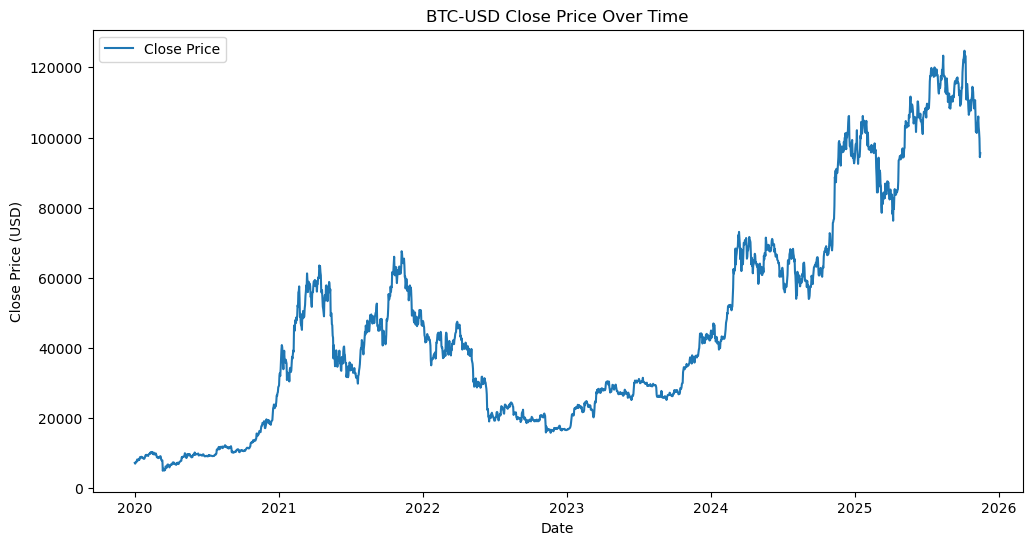

In [4]:
# Line chart of Close over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('BTC-USD Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

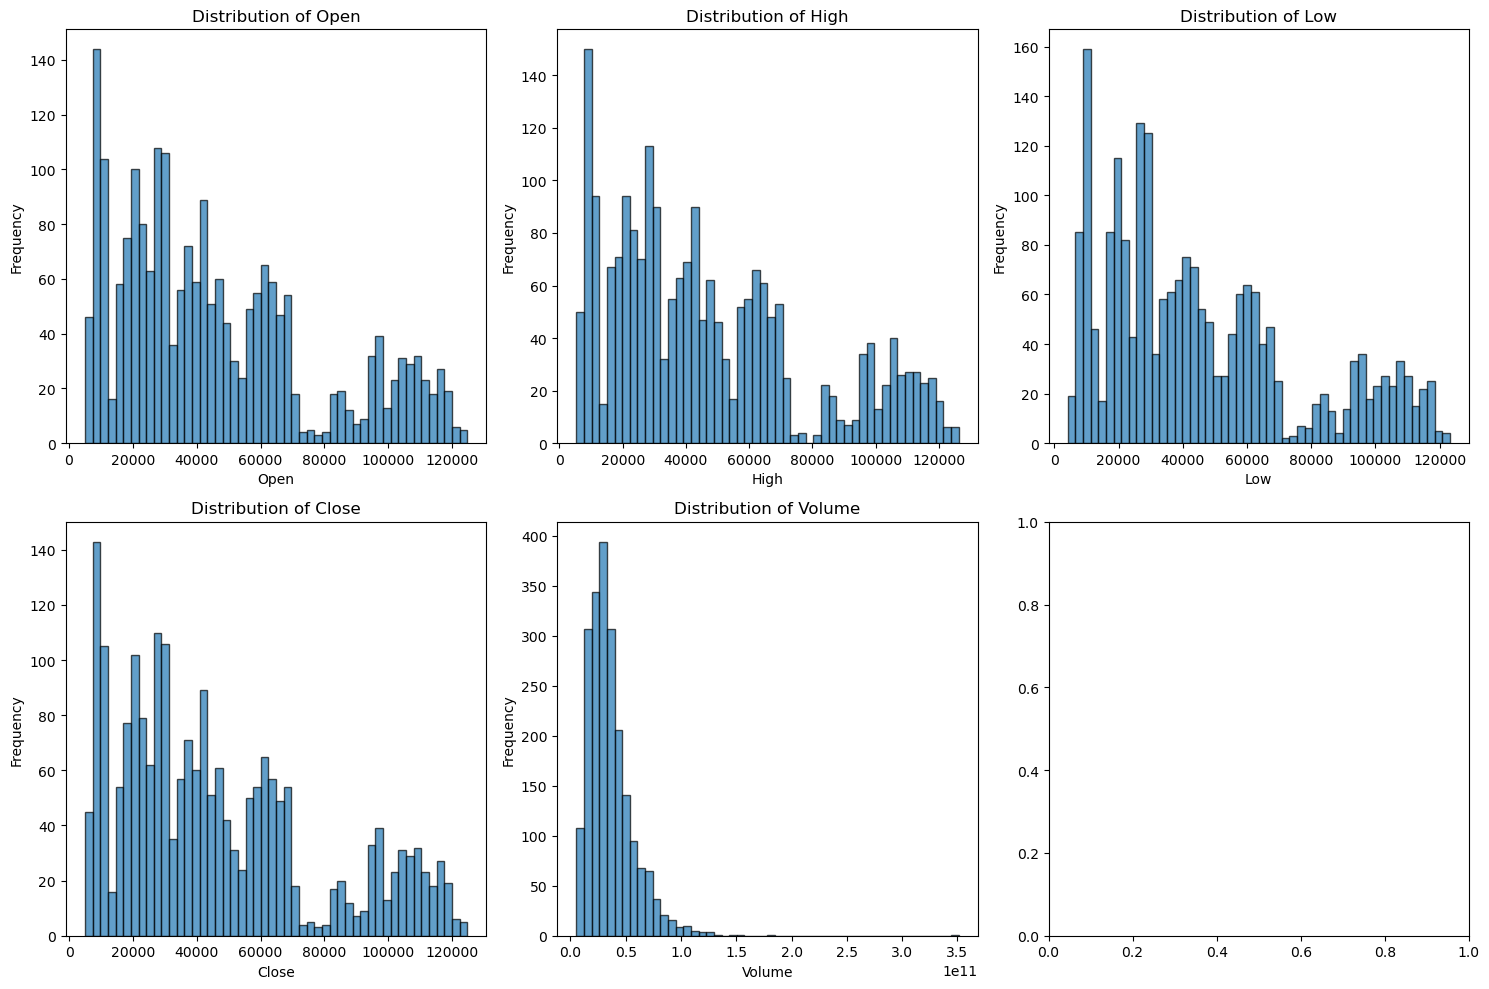

In [5]:
# Histograms for key numeric variables (Open, High, Low, Close, Volume)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

vars_to_plot = ['Open', 'High', 'Low', 'Close', 'Volume']
for idx, col in enumerate(vars_to_plot):
    axes[idx].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Part B: Moving Average and Trend Analysis

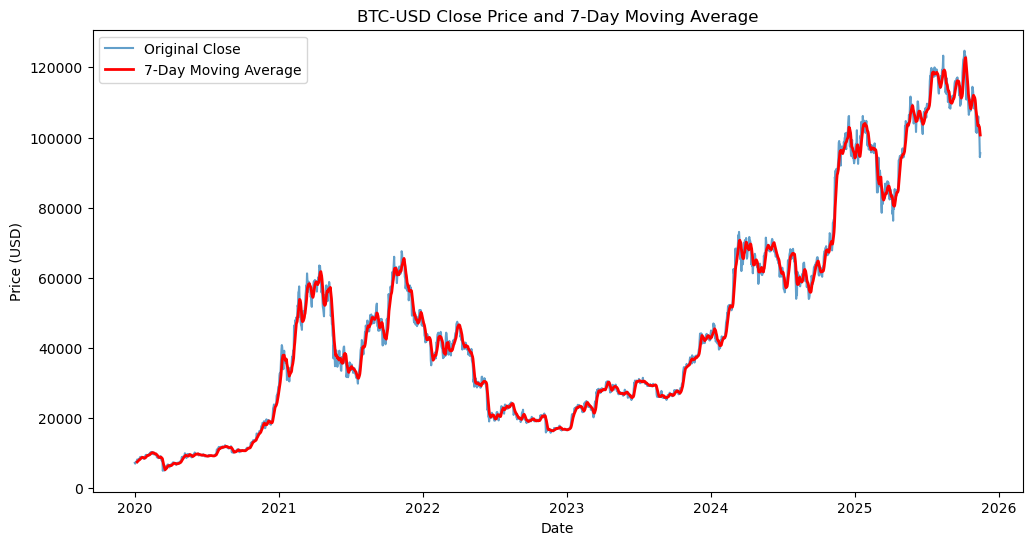

In [6]:
df['MA7'] = df['Close'].rolling(window=7).mean()  # 7-day MA for Close

# Plot original Close and MA
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original Close', alpha=0.7)
plt.plot(df.index, df['MA7'], label='7-Day Moving Average', color='red', linewidth=2)
plt.title('BTC-USD Close Price and 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# (Part C) Time Series Decomposition

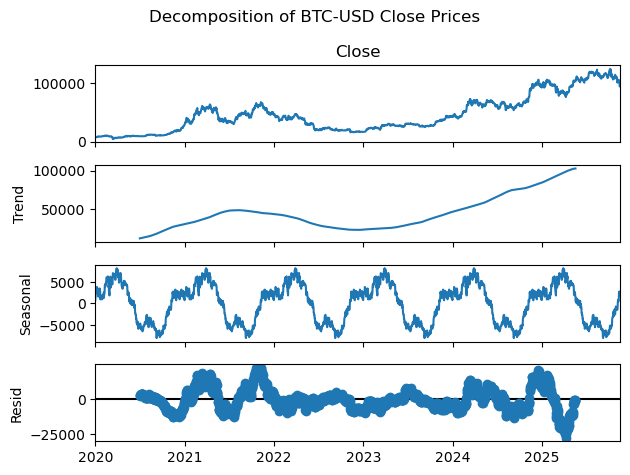

In [7]:
ts = df['Close']
decomp = seasonal_decompose(ts, model='additive', period=365) 
decomp.plot()
plt.suptitle('Decomposition of BTC-USD Close Prices')
plt.tight_layout()
plt.show()



**Explanation:** Time series decomposition separates a series into its constituent components: **Trend**, **Seasonality**, and **Residuals**. We use an additive model.
* **Observed**: The original time series data.
* **Trend**: The long-term, underlying direction of the series.
* **Seasonal**: The component representing patterns that repeat over a fixed interval.
* **Residuals**: The irregular or unsystematic component.


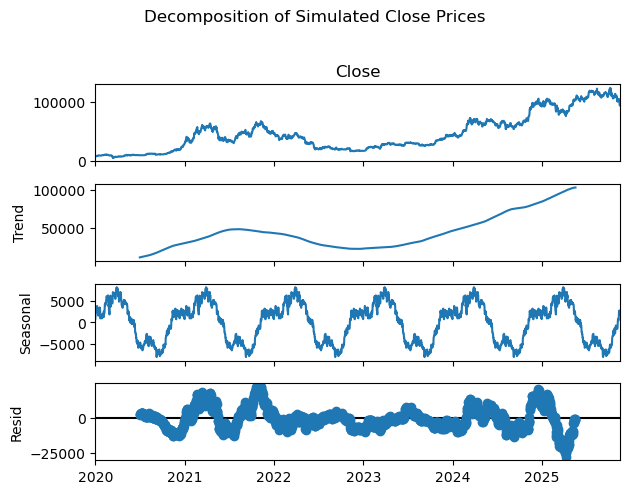

In [8]:
# Explanation
print("\n**Explanation:** Time series decomposition separates a series into its constituent components: **Trend**, **Seasonality**, and **Residuals**. We use an additive model.")
print("* **Observed**: The original time series data.")
print("* **Trend**: The long-term, underlying direction of the series.")
print("* **Seasonal**: The component representing patterns that repeat over a fixed interval.")
print("* **Residuals**: The irregular or unsystematic component.")

# Seasonal decomposition on the Close series
decomp = seasonal_decompose(ts, model='additive', period=365) # Using 365 for yearly pattern
decomp.plot()
plt.suptitle('Decomposition of Simulated Close Prices', y=1.02)
plt.tight_layout()
plt.show() 

# (Part D) Stationarity Explanation and ADF Test on Volume

In [9]:
volume = df['Volume']
adf_vol = adfuller(volume)
print('ADF Test on Volume:')
print(f'ADF Statistic: {adf_vol[0]:.4f}')
print(f'p-value: {adf_vol[1]:.4f}')
print('Critical Values:')
for key, value in adf_vol[4].items():
    print(f'   {key}: {value:.4f}')

# Interpretation
if adf_vol[1] < 0.05:
    print('\nConclusion: Volume is stationary (reject null; p < 0.05).')
else:
    print('\nConclusion: Volume is non-stationary (fail to reject null; p >= 0.05). Consider differencing.')

ADF Test on Volume:
ADF Statistic: -3.1662
p-value: 0.0220
Critical Values:
   1%: -3.4334
   5%: -2.8629
   10%: -2.5675

Conclusion: Volume is stationary (reject null; p < 0.05).


# ARIMA Modeling and Forecasting

In [10]:
# Fit ARIMA(1,0,0) on Close series
model_close = ARIMA(ts, order=(1,0,0))
fit_close = model_close.fit()
print(fit_close.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2146
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -18716.277
Date:                Thu, 20 Nov 2025   AIC                          37438.554
Time:                        11:33:18   BIC                          37455.568
Sample:                    01-01-2020   HQIC                         37444.779
                         - 11-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.63e+04   2.42e+04      1.914      0.056   -1101.048    9.37e+04
ar.L1          0.9991      0.001   1083.880      0.000       0.997       1.001
sigma2      2.196e+06   1271.683   1726.589      0.0

In [11]:
# Forecast next 30 days of Volume (separate univariate ARIMA on Volume)
forecast_steps = 30
model_vol = ARIMA(volume, order=(1,0,0))
fit_vol = model_vol.fit()
volume_forecast = fit_vol.forecast(steps=forecast_steps)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')


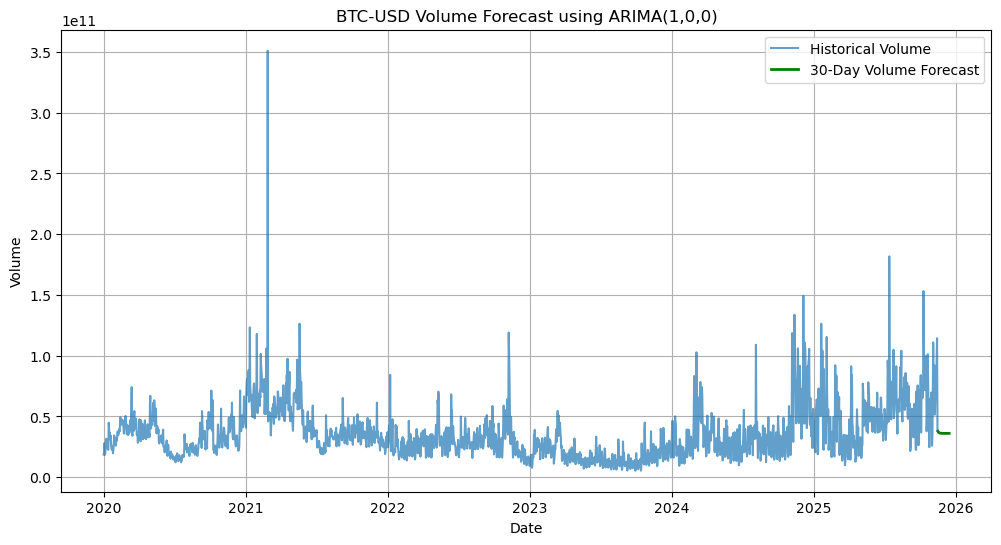

In [12]:
# Plot predicted Volume vs original
plt.figure(figsize=(12, 6))
plt.plot(df.index, volume, label='Historical Volume', alpha=0.7)
plt.plot(future_dates, volume_forecast, label='30-Day Volume Forecast', color='green', linewidth=2)
plt.title('BTC-USD Volume Forecast using ARIMA(1,0,0)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model using Mean Absolute Error (MAE) and Comment

In [13]:
from sklearn.metrics import mean_absolute_error

# 1. Fit ARIMA(1,0,0) on Close Series (Per instructions)
print("--- ARIMA on Close Price ---")
model_close = ARIMA(df['Close'], order=(1, 0, 0))
results_close = model_close.fit()
print(results_close.summary().tables[1])



--- ARIMA on Close Price ---
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.63e+04   2.42e+04      1.914      0.056   -1101.048    9.37e+04
ar.L1          0.9991      0.001   1083.880      0.000       0.997       1.001
sigma2      2.196e+06   1271.683   1726.589      0.000    2.19e+06     2.2e+06


In [14]:
# 2. Evaluation: Train/Test Split for Volume
# We split the data to test how well the model performs on known data
train_data = df['Volume'].iloc[:-30]
test_data = df['Volume'].iloc[-30:]

# Fit ARIMA on Training Data
model_vol_train = ARIMA(train_data, order=(1, 0, 0))
results_vol_train = model_vol_train.fit()

# Forecast on the Test Data timeframe
forecast_test = results_vol_train.forecast(steps=30)
# 3. Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, forecast_test)
print(f"\nMean Absolute Error (MAE) on Test Data: {mae:.2f}")




Mean Absolute Error (MAE) on Test Data: 29448631906.38


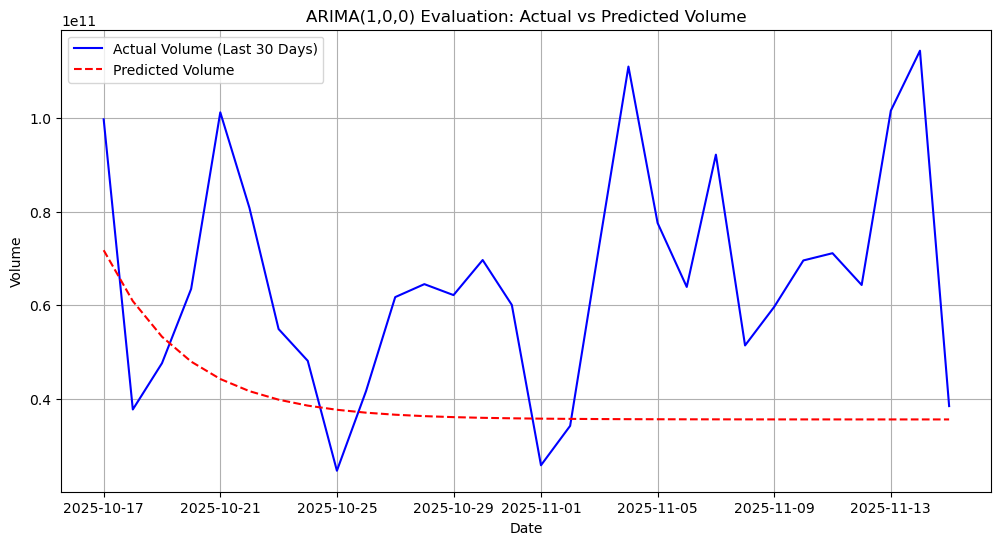

In [15]:
# 4. Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual Volume (Last 30 Days)', color='blue')
plt.plot(test_data.index, forecast_test, label='Predicted Volume', color='red', linestyle='--')
plt.title('ARIMA(1,0,0) Evaluation: Actual vs Predicted Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# 5. Future Forecast (Next 30 Days from today)
# Now we fit on the ENTIRE dataset to predict the unknown future
model_vol_full = ARIMA(df['Volume'], order=(1, 0, 0))
results_vol_full = model_vol_full.fit()
future_forecast = results_vol_full.forecast(steps=30)

print("\nFuture 30-Day Volume Forecast (First 5 days):")
print(future_forecast.head())


Future 30-Day Volume Forecast (First 5 days):
2025-11-16    3.777119e+10
2025-11-17    3.726069e+10
2025-11-18    3.690346e+10
2025-11-19    3.665349e+10
2025-11-20    3.647857e+10
Freq: D, Name: predicted_mean, dtype: float64
